In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
# cell border experimental code: 

import numpy as np
from scipy.spatial import ConvexHull

df = pd.read_csv('data/cluster_position _Detailed.csv', skiprows=3)
print(df.head()) 

   Position X  Position Y  Position Z Unit Category Collection  Time  ID  \
0   49529.578   44229.441       1.116   µm  Surface   Position     1   0   
1   49467.621   44290.391       0.977   µm  Surface   Position     1   1   
2   49515.867   44246.172       0.776   µm  Surface   Position     1   2   
3   49315.445   44443.277       2.803   µm  Surface   Position     1   3   
4   49557.926   44204.316       2.187   µm  Surface   Position     1   4   

   Unnamed: 8  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.neighbors import NearestNeighbors

# ---------------------------------------------------------------------
# ASSUMPTION: `df` is your existing DataFrame with columns
# 'Position X' and 'Position Y' (and any other columns you need).
# ---------------------------------------------------------------------

# 1) Extract (X, Y) coordinates from your DataFrame
pts = df[['Position X', 'Position Y']].values  # shape (N, 2)

# ---------------------------------------------------------------------
# PART A: COMPUTE distance‐to‐CONVEX HULL FOR EACH POINT
# ---------------------------------------------------------------------

# 2) Build the convex hull of all points
hull = ConvexHull(pts)
edges = hull.simplices  # Each row is a pair of indices [i, j] forming an edge

# 3) Define a vectorized function that returns the distance from every point to a single segment
def point_to_segment_distances(points, seg_start, seg_end):
    """
    points:   (N, 2) array of (x, y) coordinates
    seg_start, seg_end: each a length‐2 array giving the endpoints of one hull edge
    returns:  (N,) array of distances from each point to this line segment
    """
    v = seg_end - seg_start                      # Vector along the segment
    w = points - seg_start                       # Vectors from seg_start to each point
    # Projection factor t of each point onto the infinite line:  t = (w·v)/(v·v)
    t = np.einsum('ij,j->i', w, v) / np.dot(v, v)
    # Clamp t into [0, 1] so points outside the segment project to an endpoint
    t_clamped = np.clip(t, 0.0, 1.0)             # (N,)
    proj = seg_start + t_clamped[:, None] * v    # (N, 2): projected points on the segment
    # Euclidean distance from each point to its projection
    return np.linalg.norm(points - proj, axis=1)

# 4) Initialize an array of “infinite” distances, one per point
all_dists = np.full(len(pts), np.inf)

# 5) For each hull edge, compute the point‐to‐segment distances and keep the minimum
for i, j in edges:
    start, end = pts[i], pts[j]
    d = point_to_segment_distances(pts, start, end)
    all_dists = np.minimum(all_dists, d)

# 6) Attach these min‐distances back to the DataFrame
df['dist_to_hull'] = all_dists

# ---------------------------------------------------------------------
# PART B: COMPUTE Nearest‐Neighbor Distance (NND) and Local Density (LD)
# ---------------------------------------------------------------------

# 7) Nearest‐Neighbor Distance (excluding the point itself):
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(pts)
distances, _indices = nbrs.kneighbors(pts)
# distances[:, 0] is always 0 (distance to itself); distances[:, 1] is the nearest OTHER point
df['NND'] = distances[:, 1]

# 8) Local Density: count how many neighbors lie within a fixed radius r
radius = 7.5  # <-- adjust this radius (in the same units as Position X/Y) to suit your needs
nbrs_radius = NearestNeighbors(radius=radius, algorithm='ball_tree').fit(pts)
indices_within_radius = nbrs_radius.radius_neighbors(pts, return_distance=False)
# For each point, #neighbors within radius minus one (to exclude the point itself)
df['LD'] = [len(neighbors) - 1 for neighbors in indices_within_radius]

# ---------------------------------------------------------------------
# 9) Inspect the first few rows to confirm the new columns
# ---------------------------------------------------------------------
df 


,Position X,Position Y,Position Z,Unit,Category,Collection,Time,ID,Unnamed: 8,dist_to_hull,NND,LD
0,49529.578,44229.441,1.116,µm,Surface,Position,1,0,NaN,50.176982,6.253532,3
1,49467.621,44290.391,0.977,µm,Surface,Position,1,1,NaN,89.600726,6.934910,1
2,49515.867,44246.172,0.776,µm,Surface,Position,1,2,NaN,57.978679,6.661128,1
3,49315.445,44443.277,2.803,µm,Surface,Position,1,3,NaN,31.777766,7.634635,0
4,49557.926,44204.316,2.187,µm,Surface,Position,1,4,NaN,31.090851,10.936193,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20219,47583.918,41356.871,3.285,µm,Surface,Position,1,20219,NaN,130.581855,5.469139,2
20220,47669.691,41268.441,-1.012,µm,Surface,Position,1,20220,NaN,135.363585,6.106459,1
20221,47700.023,41240.758,0.904,µm,Surface,Position,1,20221,NaN,108.228682,5.426361,1
20222,47647.992,41296.988,0.550,µm,Surface,Position,1,20222,NaN,153.115935,7.277782,1


In [18]:
df = df[['Position X', 'Position Y','NND', 'LD']]
df

,Position X,Position Y,NND,LD
0,49529.578,44229.441,6.253532,3
1,49467.621,44290.391,6.934910,1
2,49515.867,44246.172,6.661128,1
3,49315.445,44443.277,7.634635,0
4,49557.926,44204.316,10.936193,0
...,...,...,...,...
20219,47583.918,41356.871,5.469139,2
20220,47669.691,41268.441,6.106459,1
20221,47700.023,41240.758,5.426361,1
20222,47647.992,41296.988,7.277782,1


Label counts: {np.int64(-1): np.int64(15), np.int64(0): np.int64(1486), np.int64(1): np.int64(266), np.int64(2): np.int64(5), np.int64(3): np.int64(208), np.int64(4): np.int64(222), np.int64(5): np.int64(197), np.int64(6): np.int64(710), np.int64(7): np.int64(346), np.int64(8): np.int64(359), np.int64(9): np.int64(352), np.int64(10): np.int64(134), np.int64(11): np.int64(464), np.int64(12): np.int64(211), np.int64(13): np.int64(141), np.int64(14): np.int64(698), np.int64(15): np.int64(332), np.int64(16): np.int64(144), np.int64(17): np.int64(767), np.int64(18): np.int64(169), np.int64(19): np.int64(231), np.int64(20): np.int64(363), np.int64(21): np.int64(247), np.int64(22): np.int64(283), np.int64(23): np.int64(90), np.int64(24): np.int64(567), np.int64(25): np.int64(242), np.int64(26): np.int64(109), np.int64(27): np.int64(304), np.int64(28): np.int64(2590), np.int64(29): np.int64(191), np.int64(30): np.int64(219), np.int64(31): np.int64(129), np.int64(32): np.int64(114), np.int64(33

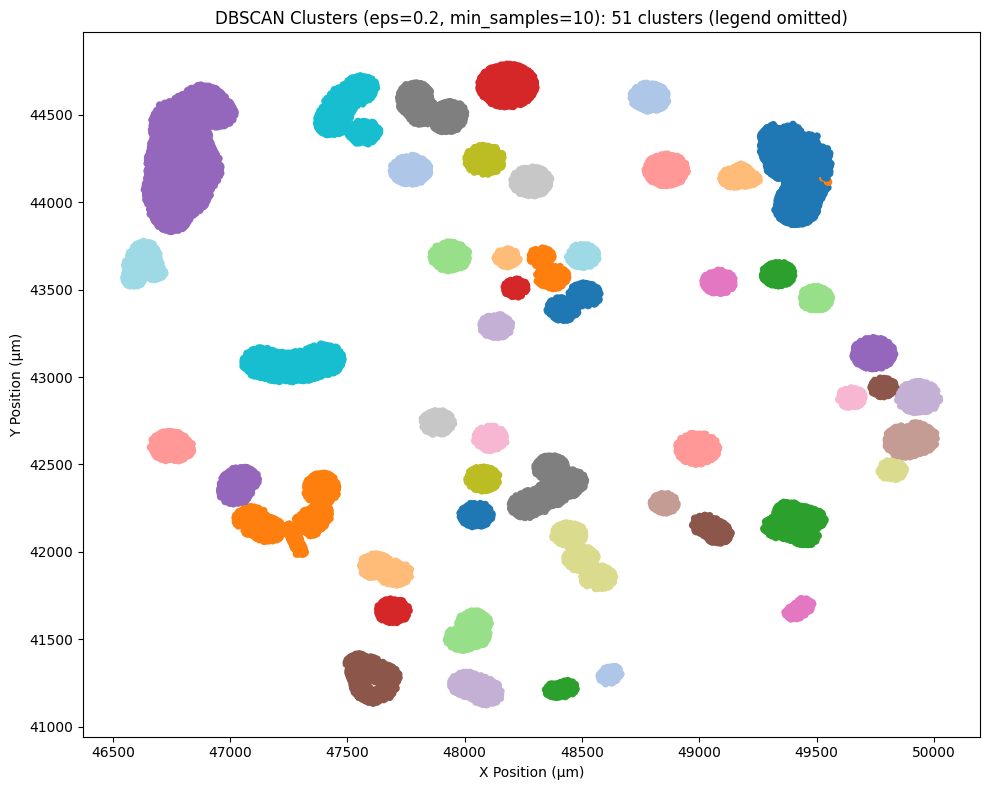

In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Extract & scale
coords = df[['Position X', 'Position Y']].values
coords_scaled = StandardScaler().fit_transform(coords)

# 2) Run DBSCAN with a “reasonable” eps/min_samples (increase eps if you get all noise)
dbscan = DBSCAN(eps=0.02, min_samples=7)  # ← tweak these until you see clusters
labels = dbscan.fit_predict(coords_scaled)

# 3) Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("Label counts:", dict(zip(unique_labels, counts)))
# e.g. { -1: 5000, 0: 2000, 1: 1500, 2: 1000, … }

# 4) Filter out noise if desired
mask = (labels != -1)
filtered_coords = coords[mask]
filtered_labels = labels[mask]

# 5) Build DataFrame for plotting
df_plot = pd.DataFrame(filtered_coords, columns=['POSITION X', 'POSITION Y'])
# Convert to string so seaborn treats each cluster as a distinct category
df_plot['cluster'] = filtered_labels.astype(str)

plt.figure(figsize=(10, 8))

# Decide whether to show legend
n_clusters = len([label for label in unique_labels if label != -1])
if n_clusters > 10:
    # Too many clusters → disable legend
    sns.scatterplot(
        data=df_plot,
        x='POSITION X', y='POSITION Y',
        hue='cluster',
        palette='tab20',   # tab20 can color up to 20 distinct categories
        s=30, linewidth=0,
        legend=False       # ← no legend box
    )
    plt.title(f'DBSCAN Clusters (eps=0.2, min_samples=10): {n_clusters} clusters (legend omitted)')
else:
    # Few clusters → show full legend
    sns.scatterplot(
        data=df_plot,
        x='POSITION X', y='POSITION Y',
        hue='cluster',
        palette='tab20',
        s=30, linewidth=0,
        legend='full'
    )
    plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'DBSCAN Clusters (eps=0.2, min_samples=10)')

plt.xlabel('X Position (µm)')
plt.ylabel('Y Position (µm)')
plt.tight_layout()
plt.show()


k = 59 → silhouette score = 0.5760
k = 60 → silhouette score = 0.5664
k = 61 → silhouette score = 0.5638
k = 62 → silhouette score = 0.5636
k = 63 → silhouette score = 0.5642
k = 64 → silhouette score = 0.5537
k = 65 → silhouette score = 0.5527
k = 66 → silhouette score = 0.5509
k = 67 → silhouette score = 0.5478
k = 68 → silhouette score = 0.5491
k = 69 → silhouette score = 0.5477
k = 70 → silhouette score = 0.5490
k = 71 → silhouette score = 0.5480
k = 72 → silhouette score = 0.5439
k = 73 → silhouette score = 0.5452
k = 74 → silhouette score = 0.5406
k = 75 → silhouette score = 0.5382
k = 76 → silhouette score = 0.5348
k = 77 → silhouette score = 0.5344
k = 78 → silhouette score = 0.5367
k = 79 → silhouette score = 0.5300
k = 80 → silhouette score = 0.5290
k = 81 → silhouette score = 0.5214
k = 82 → silhouette score = 0.5142
k = 83 → silhouette score = 0.5115
k = 84 → silhouette score = 0.5070

Chosen k = 59 (highest silhouette score of 0.5760)


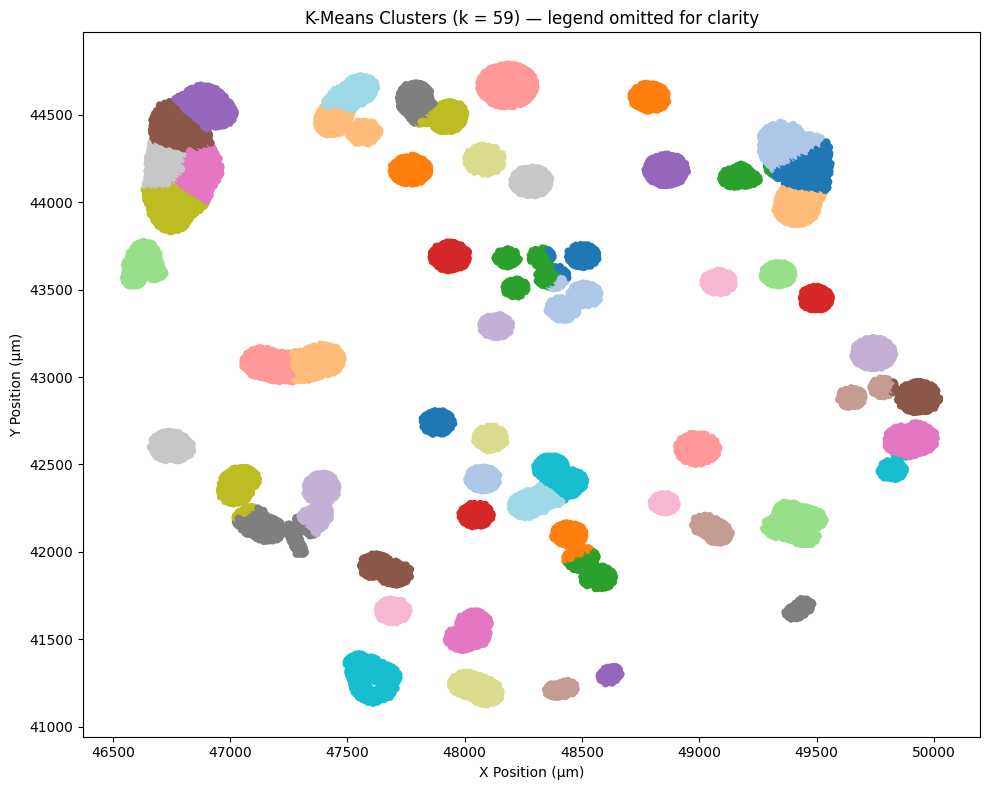

In [37]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# ASSUMPTION: `df` is your existing DataFrame with columns
# 'Position X' and 'Position Y'
# ---------------------------------------------------------------------

# 1) Extract and scale coordinates
coords = df[['Position X', 'Position Y']].values
coords_scaled = StandardScaler().fit_transform(coords)

# 2) Choose a range of k to try (e.g., 2 through 10)
k_range = range(59, 85)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(coords_scaled)
    # Compute silhouette score (only valid if there's more than one cluster)
    score = silhouette_score(coords_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k:2d} → silhouette score = {score:.4f}")

# 3) Pick the k with the highest silhouette score
best_idx = np.argmax(sil_scores)
best_k = k_range[best_idx]
print(f"\nChosen k = {best_k} (highest silhouette score of {sil_scores[best_idx]:.4f})")

# 4) Fit KMeans again using the chosen k
kmeans = KMeans(n_clusters=best_k, random_state=0)
final_labels = kmeans.fit_predict(coords_scaled)

# 5) Attach cluster labels to the DataFrame
df['kmeans_cluster'] = final_labels.astype(int)

# 6) Prepare a DataFrame for plotting (convert cluster labels to string for seaborn)
df_plot = pd.DataFrame(coords, columns=['POSITION X', 'POSITION Y'])
df_plot['cluster'] = final_labels.astype(str)

# 7) Plot the clusters
plt.figure(figsize=(10, 8))

n_clusters = best_k
if n_clusters > 10:
    # If there are more than 10 clusters, omit the legend
    sns.scatterplot(
        data=df_plot,
        x='POSITION X', y='POSITION Y',
        hue='cluster',
        palette='tab20',
        s=30, linewidth=0,
        legend=False
    )
    plt.title(f'K-Means Clusters (k = {best_k}) — legend omitted for clarity')
else:
    sns.scatterplot(
        data=df_plot,
        x='POSITION X', y='POSITION Y',
        hue='cluster',
        palette='tab10',
        s=30, linewidth=0,
        legend='full'
    )
    plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'K-Means Clusters (k = {best_k})')

plt.xlabel('X Position (µm)')
plt.ylabel('Y Position (µm)')
plt.tight_layout()
plt.show()
